In [68]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [69]:
data = pd.read_csv("data.csv")
data['concentration'] = 100*(data['gram sugar'])/ (data['gram sugar']+data['gram water'])
column_order = ['concentration', 'incident', 'refracted', 'uncertainty (±)']
data = data[column_order]

print(data)

data['incident_comp'] = 90 - data['incident'] 
data['refracted_comp'] = 90 - data['refracted']


    concentration  incident  refracted  uncertainty (±)
0             NaN        15       46.5                1
1             NaN        20       48.0                1
2             NaN        30       50.0                1
3             NaN        40       58.0                1
4             NaN        50       63.0                1
5             NaN        60       69.0                1
6             NaN        70       72.0                1
7             NaN        75       76.0                1
8             NaN        90       90.0                1
9        0.000000        10       45.0                1
10       0.000000        30       50.0                1
11       0.000000        50       62.0                1
12       0.000000        60       65.0                1
13       0.000000        70       73.0                1
14       0.000000        80       82.0                1
15       0.000000        90       90.0                1
16       1.719902        30       49.0          

Snell's Law is:

$$
n_1 \sin \theta_1 = n_2 \sin \theta_2
$$

to find $n_2$, we have
$$
n_2 = \frac{n_1\sin\theta_1}{\sin\theta_2}
$$

For error propagation, with uncertainties $\delta\theta_m$, $m=1,2$ ($n_1$ is the index of refraction of air, virtually no uncertainty)

$$
\delta n_2 = n_2 \sqrt{\left(\cos\theta_1 \frac{\delta\theta_1}{\sin\theta_1}\right)^2+\left(\cos\theta_2 \frac{\delta\theta_2}{\sin\theta_2}\right)^2}
$$

Alternatively, we can just get the $\text{SDOM}$ of the result
$$
\sigma_{\overline{n}} = \frac{\sigma_n}{\sqrt{N}}
$$
where $N$ is the number of measurements (count)

In [70]:
import pandas as pd
import numpy as np

data2 = pd.read_csv("data2.csv")
data2['concentration'] = 100*(data2['sugar'])/ (data2['sugar']+data2['water'])
column_order = ['concentration', 'incident', 'refracted']
data2 = data2[column_order]

print(data2)

data2['incident_comp'] = 90 - data2['incident'] 
data2['refracted_comp'] = 90 - data2['refracted']


    concentration  incident  refracted
0        5.008636        29         50
1        5.008636        36         54
2        5.008636        50         63
3        5.008636        19         45
4        5.008636        10         44
5       14.965986        10         45
6       14.965986        16         46
7       14.965986        29         51
8       14.965986        44         59
9       14.965986        35         53
10      20.000000        16         46
11      20.000000        28         51
12      20.000000        39         55
13      20.000000        44         59
14      20.000000        20         47
15      29.971989        16         46
16      29.971989        22         48
17      29.971989        33         53
18      29.971989        44         59
19      29.971989        10         45


In [71]:
data2['incident'] = data2['incident_comp']
data2['refracted'] = data2['refracted_comp']

# Convert angles and uncertainty to radians
incident_rad = np.deg2rad(data2['incident'])
refracted_rad = np.deg2rad(data2['refracted'])

# Calculate sines and their uncertainties
data2['sin(i)'] = np.sin(incident_rad)
data2['sin(r)'] = np.sin(refracted_rad)

# 4. CORRECTED SNELL'S LAW CALCULATION:
# n_substrate = (n_air * sin(incident)) / sin(refracted)
n_air = 1.0003
data2['n_substrate'] = (n_air * data2['sin(i)']) / data2['sin(r)']


# Display the important columns to verify
print(data2)

    concentration  incident  refracted  incident_comp  refracted_comp  \
0        5.008636        61         40             61              40   
1        5.008636        54         36             54              36   
2        5.008636        40         27             40              27   
3        5.008636        71         45             71              45   
4        5.008636        80         46             80              46   
5       14.965986        80         45             80              45   
6       14.965986        74         44             74              44   
7       14.965986        61         39             61              39   
8       14.965986        46         31             46              31   
9       14.965986        55         37             55              37   
10      20.000000        74         44             74              44   
11      20.000000        62         39             62              39   
12      20.000000        51         35             

In [72]:
# 1. Group the data by concentration (this will include the NaN group)
g2 = data2.groupby('concentration')#,  dropna=False)

# 2. Calculate statistics for each group using apply() to handle NaN values
def safe_mean(series):
    """Calculate mean of series, ignoring NaN values"""
    return series.dropna().mean() if not series.dropna().empty else np.nan

def safe_std(series):
    """Calculate std of series, ignoring NaN values"""
    return series.dropna().std() if len(series.dropna()) > 1 else np.nan

def safe_count(series):
    """Count non-NaN values in series"""
    return series.dropna().count()

rdf2 = pd.DataFrame({
    'n_mean': g2['n_substrate'].apply(safe_mean),
    'n_std': g2['n_substrate'].apply(safe_std),
    'n_measurements': g2['n_substrate'].apply(safe_count),
})

# 3. Calculate SDOM using non-NaN counts
rdf2['n_sdom'] = rdf2['n_std'] / np.sqrt(rdf2['n_measurements'])

# Reset index to make 'concentration' a regular column instead of the index
rdf2 = rdf2.reset_index()

# Round values for display (does not modify actual data, just for printing)
ddf2 = rdf2.copy()
ddf2['concentration'] = ddf2['concentration'].round(2)
ddf2['n_mean'] = ddf2['n_mean'].round(2)
ddf2['n_std'] = ddf2['n_std'].round(3)  # 3 decimal places for uncertainty
ddf2['n_sdom'] = ddf2['n_sdom'].round(3)  # 3 decimal places for SDOM

# Display the results sorted by concentration
print("Summary of Results by Concentration:")
print(ddf2[['concentration','n_mean','n_sdom']].to_string(index=False))

Summary of Results by Concentration:
 concentration  n_mean  n_sdom
          5.01    1.37   0.013
         14.97    1.39   0.006
         20.00    1.38   0.008
         29.97    1.39   0.002


In [73]:
# for aesthetic plots
def science_plot(fontsize=9, scistyle=True, show_latex=True):
    # Default settings (applied to both 2D and 3D)
    if scistyle:
        import scienceplots
        plt.style.use(['science','grid','notebook'])
    if show_latex:
        plt.rcParams.update({
            # Latex Use
            'text.usetex'     : True,        # Use LaTeX for text rendering
            'font.family'     : 'serif',     # Set font family to serif
        })

    plt.rcParams.update({
        # Fontsizes
        'font.size'       : fontsize,    # General font size
        'axes.titlesize'  : fontsize,    # Font size of the axes title
        'axes.labelsize'  : fontsize,    # Font size of the axes labels
        'xtick.labelsize' : fontsize,    # Font size of the x-axis tick labels
        'ytick.labelsize' : fontsize,    # Font size of the y-axis tick labels
        'legend.fontsize' : fontsize,    # Font size of the legend
        'figure.titlesize': fontsize,    # Font size of the figure title

        # Legend
        'legend.fancybox' : False,       # Disable the fancy box for legend
        'legend.edgecolor': 'k',         # Set legend border color to black
    })

    def optional():
        # # Grid settings
        # "grid.linestyle": "--",
        # "grid.color": "gray",
        # "grid.linewidth": 1,
        # "axes.grid": True,

        # # Minor grid (default, but may be overridden for 3D)
        # "xtick.minor.visible": True,
        # "ytick.minor.visible": True,

        # # Tick settings (both major & minor)
        # "xtick.direction": "in",
        # "ytick.direction": "in",
        # "xtick.top": True,
        # "xtick.bottom": True,
        # "ytick.left": True,
        # "ytick.right": True,

        # 'colorbar.ticks.direction': 'out',

        # # Major ticks
        # "xtick.major.width": 1,
        # "ytick.major.width": 1,
        # "xtick.major.size": 5,
        # "ytick.major.size": 5,

        # # Minor ticks
        # "xtick.minor.width": 1,
        # "ytick.minor.width": 1,
        # "xtick.minor.size": 2.5,
        # "ytick.minor.size": 2.5,

        # # Spine (border) width
        # "axes.linewidth": 1
        pass 

science_plot(fontsize=9)

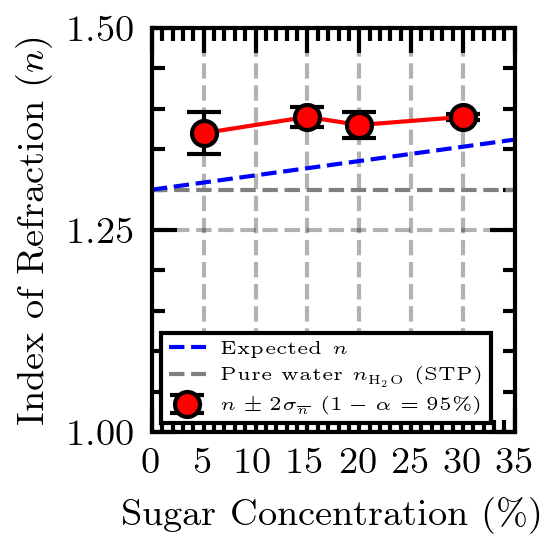

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 2), dpi=300)

perce = np.linspace(0,35,100)
nexp = 1.3 + 1.77e-3 * perce
results_df = ddf2.copy()
plt.errorbar(
    x=results_df['concentration'],
    y=results_df['n_mean'],
    yerr=2 * results_df['n_sdom'],  
    fmt='o',
    color='red',
    ecolor='black',
    markeredgecolor='black',
    markerfacecolor='red',
    capsize=4,
    elinewidth=1,
    markersize=6,
    label=r'$n \pm 2\sigma_{\overline{n}}$ ($1-\alpha = 95\%$)'
)

# Add a red line connecting the points
plt.plot(results_df['concentration'], results_df['n_mean'], 
         color='red', linestyle='-', linewidth=1, alpha=1)

# Add a red line connecting the points
plt.plot(perce,nexp, 
         color='blue', linestyle='--', linewidth=1, alpha=1, label = 'Expected $n$')

# Customize the plot
plt.xlabel(r'Sugar Concentration ($\%$)')
plt.ylabel('Index of Refraction ($n$)')

# Corrected pure water line label
plt.axhline(1.3, color='gray', linestyle='--', linewidth=1, zorder=1, 
           label=r'Pure water $n_{\mathrm{H_2O}}$ (STP)')

# Adjust y-limits to better fit your data
plt.ylim(1, 1.5) 
plt.yticks(np.arange(1, 1.75, 0.25))  
plt.xlim(0, 35)
plt.xticks(range(0,40,5))
plt.grid(True, alpha=0.3, linestyle='--')

# Improved legend with better visibility
plt.legend(fancybox=False, edgecolor='k', facecolor='white', fontsize = '4.5')

plt.tight_layout()
plt.show()

In [75]:
data['incident'] = data['incident_comp']
data['refracted'] = data['refracted_comp']

# Convert angles and uncertainty to radians
incident_rad = np.deg2rad(data['incident'])
refracted_rad = np.deg2rad(data['refracted'])
uncertainty_rad = np.deg2rad(data['uncertainty (±)'])

# Calculate sines and their uncertainties
data['sin(i)'] = np.sin(incident_rad)
data['sin(r)'] = np.sin(refracted_rad)
data['uncertainty sin(i) ±'] = np.abs(np.cos(incident_rad)) * uncertainty_rad
data['uncertainty sin(r) ±'] = np.abs(np.cos(refracted_rad)) * uncertainty_rad

# 4. CORRECTED SNELL'S LAW CALCULATION:
# n_substrate = (n_air * sin(incident)) / sin(refracted)
n_air = 1.0003
data['n_substrate'] = (n_air * data['sin(i)']) / data['sin(r)']

# Propagate the error for n_substrate
# The formula is n = n_air * (A / B), where A = sin(i), B = sin(r)
# The rule for a quotient: Δn = n * sqrt( (ΔA/A)² + (ΔB/B)² )
relative_error_sin_i = data['uncertainty sin(i) ±'] / data['sin(i)']
relative_error_sin_r = data['uncertainty sin(r) ±'] / data['sin(r)']
data['uncertainty n_substrate ±'] = data['n_substrate'] * np.sqrt(relative_error_sin_i**2 + relative_error_sin_r**2)

# Display the important columns to verify
print(data[['concentration','incident_comp','refracted_comp','uncertainty (±)','n_substrate','uncertainty n_substrate ±']])

    concentration  incident_comp  refracted_comp  uncertainty (±)  \
0             NaN             75            43.5                1   
1             NaN             70            42.0                1   
2             NaN             60            40.0                1   
3             NaN             50            32.0                1   
4             NaN             40            27.0                1   
5             NaN             30            21.0                1   
6             NaN             20            18.0                1   
7             NaN             15            14.0                1   
8             NaN              0             0.0                1   
9        0.000000             80            45.0                1   
10       0.000000             60            40.0                1   
11       0.000000             40            28.0                1   
12       0.000000             30            25.0                1   
13       0.000000             20  

In [76]:
# 1. Group the data by concentration (this will include the NaN group)
grouped = data.groupby('concentration')#,  dropna=False)

# 2. Calculate statistics for each group using apply() to handle NaN values
def safe_mean(series):
    """Calculate mean of series, ignoring NaN values"""
    return series.dropna().mean() if not series.dropna().empty else np.nan

def safe_std(series):
    """Calculate std of series, ignoring NaN values"""
    return series.dropna().std() if len(series.dropna()) > 1 else np.nan

def safe_count(series):
    """Count non-NaN values in series"""
    return series.dropna().count()

results_df = pd.DataFrame({
    'n_mean': grouped['n_substrate'].apply(safe_mean),
    'n_std': grouped['n_substrate'].apply(safe_std),
    'n_measurements': grouped['n_substrate'].apply(safe_count),
    'mean_measurement_uncertainty': grouped['uncertainty n_substrate ±'].apply(safe_mean)
})

# 3. Calculate SDOM using non-NaN counts
results_df['n_sdom'] = results_df['n_std'] / np.sqrt(results_df['n_measurements'])

# Reset index to make 'concentration' a regular column instead of the index
results_df = results_df.reset_index()

# Round values for display (does not modify actual data, just for printing)
display_df = results_df.copy()
display_df['concentration'] = display_df['concentration'].round(2)
display_df['n_mean'] = display_df['n_mean'].round(2)
display_df['n_std'] = display_df['n_std'].round(3)  # 3 decimal places for uncertainty
display_df['mean_measurement_uncertainty'] = display_df['mean_measurement_uncertainty'].round(3)  # 3 decimal places
display_df['n_sdom'] = display_df['n_sdom'].round(3)  # 3 decimal places for SDOM

# Display the results sorted by concentration
print("Summary of Results by Concentration:")
print(display_df[['concentration','n_mean','n_sdom','mean_measurement_uncertainty']].to_string(index=False))

Summary of Results by Concentration:
 concentration  n_mean  n_sdom  mean_measurement_uncertainty
          0.00    1.29   0.040                         0.075
          1.72    1.32   0.054                         0.053
          3.85    1.29   0.052                         0.067
          5.65    1.31   0.084                         0.108
          7.39    1.29   0.038                         0.081
          9.07    1.32   0.057                         0.121


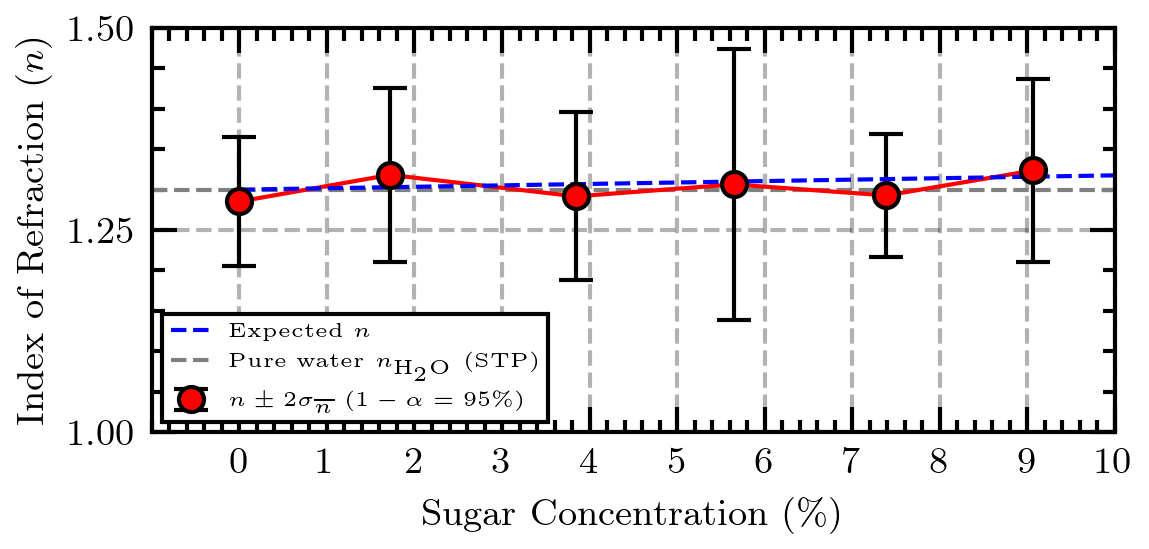

In [82]:
plt.figure(figsize=(4, 2), dpi=300)

perce = np.linspace(0,10,100)
nexp = 1.3 + 1.77e-3 * perce

plt.errorbar(
    x=results_df['concentration'],
    y=results_df['n_mean'],
    yerr=2 * results_df['n_sdom'],  
    fmt='o',
    color='red',
    ecolor='black',
    markeredgecolor='black',
    markerfacecolor='red',
    capsize=4,
    elinewidth=1,
    markersize=6,
    label=r'$n \pm 2\sigma_{\overline{n}}$ ($1-\alpha = 95\%$)'
)

# Add a red line connecting the points
plt.plot(results_df['concentration'], results_df['n_mean'], 
         color='red', linestyle='-', linewidth=1, alpha=1)

# Add a red line connecting the points
plt.plot(perce,nexp, 
         color='blue', linestyle='--', linewidth=1, alpha=1, label = 'Expected $n$')

# Customize the plot
plt.xlabel(r'Sugar Concentration ($\%$)')
plt.ylabel('Index of Refraction ($n$)')

# Corrected pure water line label
plt.axhline(1.3, color='gray', linestyle='--', linewidth=1, zorder=1, 
           label=r'Pure water $n_{\mathrm{H_2O}}$ (STP)')

# Adjust y-limits to better fit your data
plt.ylim(1, 1.5) 
plt.yticks(np.arange(1, 1.55, 0.25))  
plt.xlim(-1, 10)
plt.xticks(range(0,11,1))
plt.grid(True, alpha=0.3, linestyle='--')

# Improved legend with better visibility
plt.legend(fancybox=False, edgecolor='k', facecolor='white', fontsize = 5)

plt.tight_layout()
plt.show()

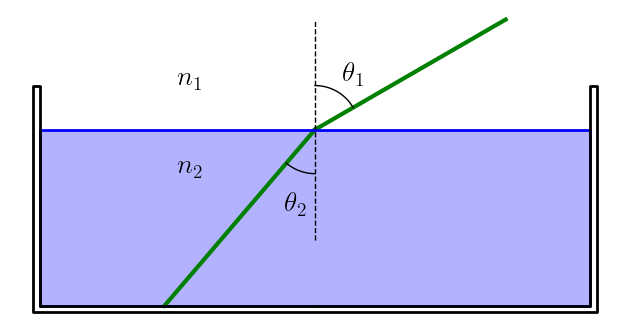

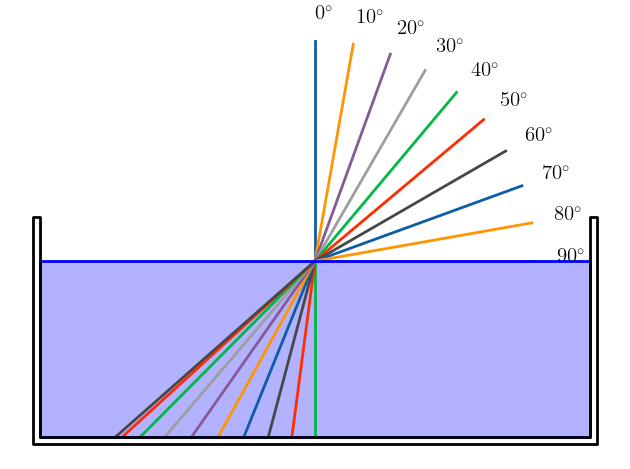

In [78]:

basin_length = 2.5
basin_height = 1 
basin_thickness = 0.03
water_height = 0.8 

basin_center = np.array([0,-water_height])
basin =np.array( [
    basin_center,
    [basin_center[0]+basin_length/2,basin_center[1]],
    [basin_center[0]+basin_length/2,basin_center[1]+basin_height],
    [basin_center[0]+basin_length/2+basin_thickness,basin_center[1]+basin_height],
    [basin_center[0]+basin_length/2+basin_thickness,basin_center[1]-basin_thickness],
    [basin_center[0]-basin_length/2-basin_thickness,basin_center[1]-basin_thickness],
    [basin_center[0]-basin_length/2-basin_thickness,basin_center[1]+basin_height],
    [basin_center[0]-basin_length/2,basin_center[1]+basin_height],
    [basin_center[0]-basin_length/2,basin_center[1]],
    basin_center
])

water = np.array([
    basin_center,
    [basin_center[0]+basin_length/2,basin_center[1]],
    [basin_center[0]+basin_length/2,basin_center[1]+water_height],
    [basin_center[0]-basin_length/2,basin_center[1]+water_height],
    [basin_center[0]-basin_length/2,basin_center[1]],
    basin_center
])

n1 = 1 
n2 = 1.333
incident_angle = np.deg2rad(60)
refracted_angle = np.arcsin(n1 * np.sin(incident_angle) / n2)
incident_ray_length = 1
incident_ray = np.array([
    [0,0],
    [np.sin(incident_angle),np.cos(incident_angle)]
])
refracted_ray = np.array([
    [0,0],
    [basin_center[1]*np.tan(refracted_angle),basin_center[1]]
])

plt.plot(incident_ray.T[0],incident_ray.T[1], color = 'g', linewidth = 3)
plt.plot(refracted_ray.T[0],refracted_ray.T[1], color = 'g', linewidth = 3)

plt.plot(water.T[0],water.T[1], color = 'b')
plt.fill(water.T[0], water.T[1], color='b', alpha=0.3)
plt.plot(basin.T[0],basin.T[1], color = 'k')

plt.plot([0,0],[-0.5,0.5], linestyle = '--',linewidth = 1, color = 'k')
plt.plot(
    0.2*np.sin(np.linspace(0,incident_angle,100)), 
    0.2*np.cos(np.linspace(0,incident_angle,100)),
    linewidth = 1,
    color = 'k',
)
plt.plot(
    -0.2*np.sin(np.linspace(0,refracted_angle,100)), 
    -0.2*np.cos(np.linspace(0,refracted_angle,100)),
    linewidth = 1,
    color = 'k',
)
plt.text(0.25*np.sin(incident_angle/2),0.25*np.cos(incident_angle/2),r'$\theta_1$',fontsize=20)
plt.text(-0.4*np.sin(refracted_angle/2),-0.4*np.cos(refracted_angle/2),r'$\theta_2$',fontsize=20)
plt.text(-basin_length/4,water_height/4,r'$n_1$',fontsize=20)
plt.text(-basin_length/4,-water_height/4,r'$n_2$',fontsize=20)
plt.axis(False)
plt.grid(False)
plt.gca().set_aspect('equal')
plt.show()

angles = range(0,100,10)
for incident_angle in angles:
    incident_angle_deg = incident_angle
    incident_angle = np.deg2rad(incident_angle)
    refracted_angle = np.arcsin(n1 * np.sin(incident_angle) / n2)
    incident_ray_length = 1
    incident_ray = np.array([
        [0,0],
        [np.sin(incident_angle),np.cos(incident_angle)]
    ])
    refracted_ray = np.array([
        [0,0],
        [basin_center[1]*np.tan(refracted_angle),basin_center[1]]
    ])

    plt.plot(incident_ray.T[0],incident_ray.T[1], linewidth = 2)
    plt.plot(refracted_ray.T[0],refracted_ray.T[1], linewidth = 2)
    plt.text(1.1*np.sin(incident_angle),1.1*np.cos(incident_angle),rf'${{{incident_angle_deg}}}^\circ$',fontsize=15)
   
plt.plot(water.T[0],water.T[1], color = 'b')
plt.fill(water.T[0], water.T[1], color='b', alpha=0.3)
plt.plot(basin.T[0],basin.T[1], color = 'k')
plt.axis(False)
plt.grid(False)
plt.gca().set_aspect('equal')
plt.show()


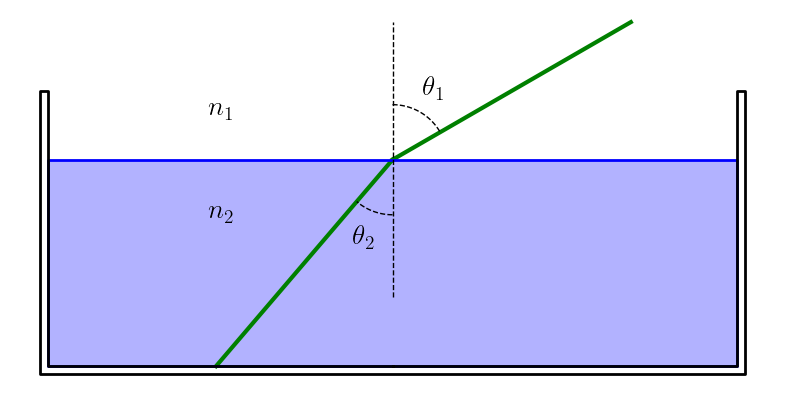

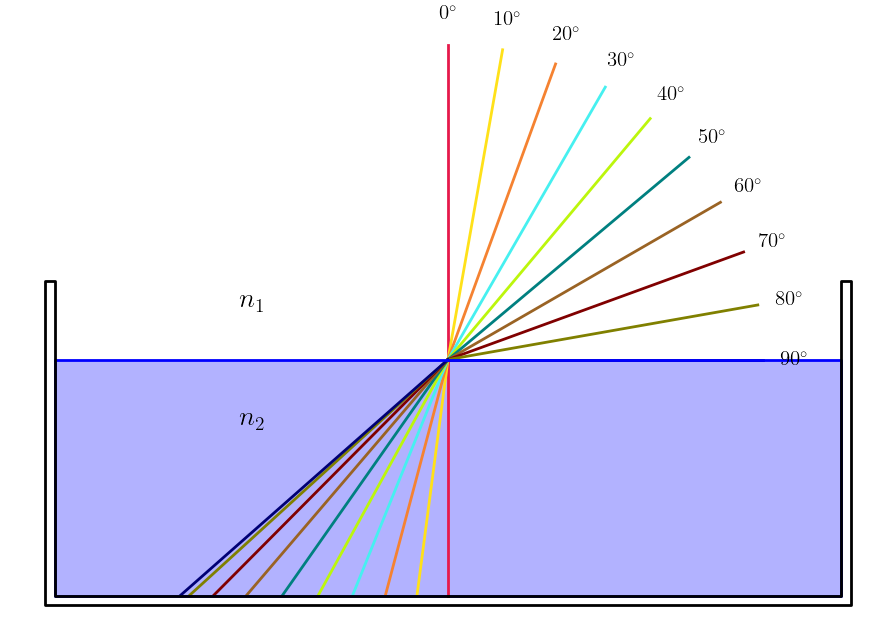

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Basin parameters
basin_length = 2.5
basin_height = 1 
basin_thickness = 0.03
water_height = 0.75
basin_center = np.array([0, -water_height])

# Define basin shape
basin = np.array([
    basin_center,
    [basin_center[0] + basin_length/2, basin_center[1]],
    [basin_center[0] + basin_length/2, basin_center[1] + basin_height],
    [basin_center[0] + basin_length/2 + basin_thickness, basin_center[1] + basin_height],
    [basin_center[0] + basin_length/2 + basin_thickness, basin_center[1] - basin_thickness],
    [basin_center[0] - basin_length/2 - basin_thickness, basin_center[1] - basin_thickness],
    [basin_center[0] - basin_length/2 - basin_thickness, basin_center[1] + basin_height],
    [basin_center[0] - basin_length/2, basin_center[1] + basin_height],
    [basin_center[0] - basin_length/2, basin_center[1]],
    basin_center
])

# Define water shape
water = np.array([
    basin_center,
    [basin_center[0] + basin_length/2, basin_center[1]],
    [basin_center[0] + basin_length/2, basin_center[1] + water_height],
    [basin_center[0] - basin_length/2, basin_center[1] + water_height],
    [basin_center[0] - basin_length/2, basin_center[1]],
    basin_center
])

# Refractive indices
n1 = 1 
n2 = 1.333

# Create a custom colormap with distinct colors
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
          '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
          '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
          '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
custom_cmap = LinearSegmentedColormap.from_list('custom_colors', colors, N=len(colors))

# First graph: Single refraction example
plt.figure(figsize=(10, 8))
incident_angle = np.deg2rad(60)
refracted_angle = np.arcsin(n1 * np.sin(incident_angle) / n2)
incident_ray_length = 1

# Incident and refracted rays
incident_ray = np.array([
    [0, 0],
    [np.sin(incident_angle), np.cos(incident_angle)]
])
refracted_ray = np.array([
    [0, 0],
    [basin_center[1] * np.tan(refracted_angle), basin_center[1]]
])

# Plot rays
plt.plot(incident_ray.T[0], incident_ray.T[1], color='g', linewidth=3)
plt.plot(refracted_ray.T[0], refracted_ray.T[1], color='g', linewidth=3)

# Plot water and basin
plt.plot(water.T[0], water.T[1], color='b')
plt.fill(water.T[0], water.T[1], color='b', alpha=0.3)
plt.plot(basin.T[0], basin.T[1], color='k')

# Add angle indicators
plt.plot([0, 0], [-0.5, 0.5], linestyle='--', linewidth=1, color='k')
plt.plot(
    0.2 * np.sin(np.linspace(0, incident_angle, 100)), 
    0.2 * np.cos(np.linspace(0, incident_angle, 100)),
    linewidth=1,
    color='k',
    linestyle = '--'
)
plt.plot(
    -0.2 * np.sin(np.linspace(0, refracted_angle, 100)), 
    -0.2 * np.cos(np.linspace(0, refracted_angle, 100)),
    linewidth=1,
    color='k',
    linestyle = '--'
)

# Add labels
plt.text(0.3 * np.sin(incident_angle/2), 0.3 * np.cos(incident_angle/2), r'$\theta_1$',ha='center', va='center', fontsize=20)
plt.text(-0.3 * np.sin(refracted_angle/2), -0.3 * np.cos(refracted_angle/2), r'$\theta_2$',ha='center', va='center', fontsize=20)
plt.text(-basin_length/4, water_height/4, r'$n_1$', ha='center', va='center', fontsize=20)
plt.text(-basin_length/4, -water_height/4, r'$n_2$',ha='center', va='center', fontsize=20)

plt.axis(False)
plt.grid(False)
plt.gca().set_aspect('equal')
plt.show()

# Second graph: Multiple rays with non-repeating colors
plt.figure(figsize=(12, 8))

# Plot multiple rays at different angles
angles = range(0, 100, 10)
for i, incident_angle_deg in enumerate(angles):
    incident_angle = np.deg2rad(incident_angle_deg)
    
    # Calculate refracted angle using Snell's law
    if np.sin(incident_angle) * n1 / n2 <= 1:  # Check for total internal reflection
        refracted_angle = np.arcsin(n1 * np.sin(incident_angle) / n2)
        
        # Incident and refracted rays
        incident_ray = np.array([
            [0, 0],
            [np.sin(incident_angle), np.cos(incident_angle)]
        ])
        refracted_ray = np.array([
            [0, 0],
            [basin_center[1] * np.tan(refracted_angle), basin_center[1]]
        ])
        
        # Get color from custom colormap
        color = custom_cmap(i / len(angles))
        
        # Plot rays
        plt.plot(incident_ray.T[0], incident_ray.T[1], color=color, linewidth=2)
        plt.plot(refracted_ray.T[0], refracted_ray.T[1], color=color, linewidth=2)
        plt.text(1.1 * np.sin(incident_angle), 1.1 * np.cos(incident_angle), 
                 rf'${{{incident_angle_deg}}}^\circ$', ha='center', va='center',fontsize=15, color='k')
    else:
        # Total internal reflection case
        incident_ray = np.array([
            [0, 0],
            [np.sin(incident_angle), np.cos(incident_angle)]
        ])
        color = custom_cmap(i / len(angles))
        plt.plot(incident_ray.T[0], incident_ray.T[1], color=color, linewidth=2, linestyle=':')
        plt.text(1.1 * np.sin(incident_angle), 1.1 * np.cos(incident_angle), 
                 rf'${{{incident_angle_deg}}}^\circ$ (TIR)', ha='center', va='center', fontsize=15, color=color)

# Plot water and basin
plt.plot(water.T[0], water.T[1], color='b')
plt.fill(water.T[0], water.T[1], color='b', alpha=0.3)
plt.plot(basin.T[0], basin.T[1], color='k')
plt.text(-basin_length/4, water_height/4, r'$n_1$', ha='center', va='center', fontsize=20)
plt.text(-basin_length/4, -water_height/4, r'$n_2$',ha='center', va='center', fontsize=20)
plt.axis(False)
plt.grid(False)
plt.gca().set_aspect('equal')
plt.show()

In [80]:
import numpy as np
from scipy.stats import linregress


concentration = np.array([0.00, 1.72, 3.85, 5.65, 7.39, 9.07, 5.01, 14.97, 20.00, 29.97])
n = np.array([1.29, 1.32, 1.29, 1.31, 1.29, 1.32, 1.37, 1.39, 1.38, 1.39])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(concentration, n)

slope, intercept, r_value**2


(np.float64(0.0035067593822862776),
 np.float64(1.3007635081507392),
 np.float64(0.5837102250825033))